In [1]:
# ME EN 4650  Lab10:Heat Exchanger Lab  Ryan Dalby    
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import matlab.engine # Must install from matlab installation direcotry using: cd "matlabroot\extern\engines\python" && python setup.py install 


In [2]:
# Define useful functions
mmhg_to_pa = lambda mmhg : mmhg*133.3 # Lambda function to covert mmHg to Pa
inh2o_to_pa = lambda inh2o : inh2o*249.04 # Lambda function to covert inH20 to Pa
in_to_m = lambda inch : inch*0.0254 # Lambda function to convert in to m
cm_to_m = lambda cm : cm/100 # Lambda function to convert cm to m
mm_to_m = lambda mm : mm/1000 # Lambda function to convert mm to m
degC_to_K = lambda degC : degC+273.15 # Lambda function to covert degC to K
degF_to_degC = lambda degF : (degF-32)*(5/9) # Lambda function to covert degF to degC
gpm_to_m3s = lambda gpm : gpm * (0.00378541/60) # Lambda function to convert gpm to kg/s

In [3]:
# AirPropeties.m wrapper for Python
# Given temperature in K and atmospheric pressure in Pa will give rho in kg/m**3, mu in kg/(m*s), k in W/(m*K), and Cp in J/(kg*K)
def AirProperties_wrapper(T,P):
    eng = matlab.engine.start_matlab()
    eng.addpath(os.path.abspath(os.getcwd()))
    rho =[]
    mu = []
    k = []
    cp = []
    if(not isinstance(T,np.ndarray)):
        T = np.array([T])
    if(not isinstance(P,np.ndarray)):
        if(np.size(T) != np.size(P)):
            P = np.full(np.size(T),P)
        else: 
            P = np.array([P]) 
    for i in range(np.size(T)):
        matlab_output = eng.AirProperties(float(T[i]),float(P[i]),nargout=4)
        rho.append(matlab_output[0])
        mu.append(matlab_output[1])
        k.append(matlab_output[2])
        cp.append(matlab_output[3])
    eng.quit()
    return (np.array(rho), np.array(mu), np.array(k), np.array(cp))

In [4]:
# WaterProperties.m wrapper for Python
# Given temperature in degC will give rho in kg/m**3 and Cp in J/(kg*K)
def WaterProperties_wrapper(T):
    eng = matlab.engine.start_matlab()
    eng.addpath(os.path.abspath(os.getcwd()))
    rho =[]
    cp = []
    if(not isinstance(T,np.ndarray)):
        T = np.array([T])
    for i in range(np.size(T)):
        matlab_output = eng.WaterProperties(float(T[i]),nargout=2)
        rho.append(matlab_output[0])
        cp.append(matlab_output[1])
    eng.quit()
    return (np.array(rho), np.array(cp))


In [5]:
# Experimental Geometry 
Do_tube = in_to_m(0.25) # Tube outside diameter in m
t_tube = in_to_m(0.028) # Tube wall thickness
Di_tube = Do_tube - 2*t_tube # Tube inside diameter in m
L_shellandtube = in_to_m(9) # Shell and tube length in m
N_tube = 31 # Number of tubes
D_shell = in_to_m(2.12) # Outer diameter of the shell in m
g = 9.81 # Gravitational constant in  m/s**2

# Experimental Data (For case 1a, 1b, 2a, 2b respectively)
Patm = mmhg_to_pa(661) # Atmospheric pressure in Pa
Th_i = degF_to_degC(np.array([114.2,115.7,113.9,116.3])) # Hot side inlet temperature in degC
Th_o = degF_to_degC(np.array([104.9,103.1,106.7,103.9])) # Hot side outlet temperature in degC
Tc_i = degF_to_degC(np.array([51.8,51.5,51.5,51.2])) # Cold side inlet temperature in degC
Tc_o = degF_to_degC(np.array([64.0,63.7,64.4,63.8])) # Cold side outlet temperature in degC
Tshell = degF_to_degC(np.array([95.6,96.8,97.2,97.1])) # Temperature of the shell casing
Tamb = degF_to_degC(np.array([70.4,70.5,70.4,70.2])) # Temperature of ambient air 
Vdot_c = gpm_to_m3s(np.array([3.8,3.7,3.2,3.4])) # Volumetric flow rate of cold side inlet
Vdot_h = gpm_to_m3s(np.array([4.6,3.0,5.2,3.0])) # Volumetric flow rate of hot side inlet


In [6]:
# Experimental calculations 
Tc_avg = 0.5*(Tc_i+Tc_o)
Th_avg = 0.5*(Th_i+Th_o)
waterprop_c = WaterProperties_wrapper(Tc_avg)
rho_c = waterprop_c[0]
cp_c = waterprop_c[1]
waterprop_h = WaterProperties_wrapper(Th_avg)
rho_h = waterprop_h[0]
cp_h = waterprop_h[1]
mc_dot = rho_c*Vdot_c
mh_dot = rho_h*Vdot_h
Ch = mh_dot*cp_h
Cc = mc_dot*cp_c
Cmin = np.minimum(Ch, Cc) 
Cmax = np.maximum(Ch, Cc) 
Cr = Cmin/Cmax
qh = Ch*(Th_i-Th_o)
qc = Cc*(Tc_o-Tc_i)
epsilon = qh/(Cmin*(Th_i-Tc_i))
deltaT1 = Th_i-Tc_o
deltaT2 = Th_o-Tc_i
deltaTlm = (deltaT1 - deltaT2)/(np.log(deltaT1/deltaT2))
F = 1 # Correction factor for a counterflow, single-tube-pass, shell and tube heat exchanger
Ai = N_tube * np.pi * Di_tube * L_shellandtube  # Inside tube area in m^2
Ui = qh/(Ai*F*deltaTlm)
NTU = (Ui*Ai)/Cmin


In [7]:
# Theoretical calculations
epsilon_ther = (1-np.exp(-NTU*(1-Cr)))/(1-Cr*np.exp(-NTU*(1-Cr))) # We assume that Cr < 1

# Theoretical heat transfer rate from convection calculation
Tf_air = (Tshell + Tamb)/2
airprop = AirProperties_wrapper(degC_to_K(Tf_air), Patm)
rho_air = airprop[0]
mu_air = airprop[1]
k_air = airprop[2]
cp_air = airprop[3]
beta_air = 1/degC_to_K(Tf_air) # Coefficient of thermal expansion assuming that air is an ideal gas
alpha_air = k_air/(rho_air*cp_air)
nu_air = mu_air/rho_air
Pr = nu_air/alpha_air
RaD_air = (g * beta_air * (Tshell-Tamb) * D_shell**3)/(nu_air*alpha_air) # Rayleigh number for air
# NuD_bar = (0.6 + (0.387*RaD_air**(1/6))/(1+(0.559/Pr)**9/16)**(8/27))**2
NuD_bar = 0.48*RaD_air**(1/4)
qconv = k_air * NuD_bar * (Tshell-Tamb) * np.pi * L_shellandtube

# Theoretical heat transfer rate from radiation calculation
emissitivity = 0.95 # Approximation of emissivity
sigma = 5.6703e-8 # Stefan Boltzmann constant in W/(m**2*K**4)
qrad = emissitivity * sigma * (degC_to_K(Tshell)**4-degC_to_K(Tamb)**4)*np.pi*D_shell*L_shellandtube

# Percent uncertainty in measured heat rates
deltaTc = Tc_o-Tc_i
deltaTh = Th_i-Th_o
sigma_vdot_h = gpm_to_m3s(0.2) # +/- m**3/s
sigma_vdot_c = sigma_vdot_h # +/- m**3/s
sigma_deltaTh = 0.1 # +/- degC
sigma_deltaTc = sigma_deltaTh # +/- degC
sigmaq_c_per_qc = np.sqrt((sigma_vdot_c/Vdot_c)**2 + (sigma_deltaTc/deltaTc)**2) * 100
sigmaq_h_per_qh = np.sqrt((sigma_vdot_h/Vdot_h)**2 + (sigma_deltaTh/deltaTh)**2) * 100


In [8]:
# Table 1a
# Note printed vector values correspond to case 1a, 1b, 2a, 2b respectively by index
np.set_printoptions(precision=3)
print('Table 1a values:')
print('Flow rate: mc_dot = {:s} kg/s    mh_dot = {:s} kg/s'.format(str(mc_dot), str(mh_dot)))
print('Temperature: deltaTh = {:s} degC    deltaTc = {:s} degC'.format(str(deltaTh), str(deltaTc)))
print('Ui: Ui = {:s} W/(K*m**2)'.format(str(Ui)))
deltaq = np.abs(qh-qc)/(0.5 * (qh+qc)) * 100 # In %
print('Heat transfer rate: qc = {:s} kW    qh = {:s} kW    deltaq = {:s} %'.format(str(qc/1000), str(qh/1000), str(deltaq))) # In kW


Table 1a values:
Flow rate: mc_dot = [0.24  0.233 0.202 0.214] kg/s    mh_dot = [0.288 0.188 0.325 0.188] kg/s
Temperature: deltaTh = [5.167 7.    4.    6.889] degC    deltaTc = [6.778 6.778 7.167 7.   ] degC
Ui: Ui = [1973.454 1738.278 1705.013 1684.432] W/(K*m**2)
Heat transfer rate: qc = [6.803 6.625 6.058 6.288] kW    qh = [6.211 5.488 5.435 5.4  ] kW    deltaq = [ 9.111 18.776 10.847 15.189] %


In [9]:
# Table 1b
# Note printed vector values correspond to case 1a, 1b, 2a, 2b respectively by index
np.set_printoptions(precision=3)
print('Table 1b values:')
print('Flow rate: mc_dot = {:s} kg/s    mh_dot = {:s} kg/s'.format(str(mc_dot), str(mh_dot)))
print('Cr: Cr = {:s}'.format(str(Cr)))
print('NTU: NTU = {:s}'.format(str(NTU)))
deltaepsilon = (np.abs(epsilon-epsilon_ther)/epsilon_ther) * 100 # In %
print('Effectiveness: measured = {:s}    theory = {:s}    deltaepsilon = {:s} %'.format(str(epsilon), str(epsilon_ther), str(deltaepsilon)))


Table 1b values:
Flow rate: mc_dot = [0.24  0.233 0.202 0.214] kg/s    mh_dot = [0.288 0.188 0.325 0.188] kg/s
Cr: Cr = [0.835 0.802 0.622 0.873]
NTU: NTU = [0.216 0.243 0.221 0.236]
Effectiveness: measured = [0.178 0.196 0.185 0.19 ]    theory = [0.18  0.199 0.188 0.193]    deltaepsilon = [0.865 1.616 1.098 1.36 ] %


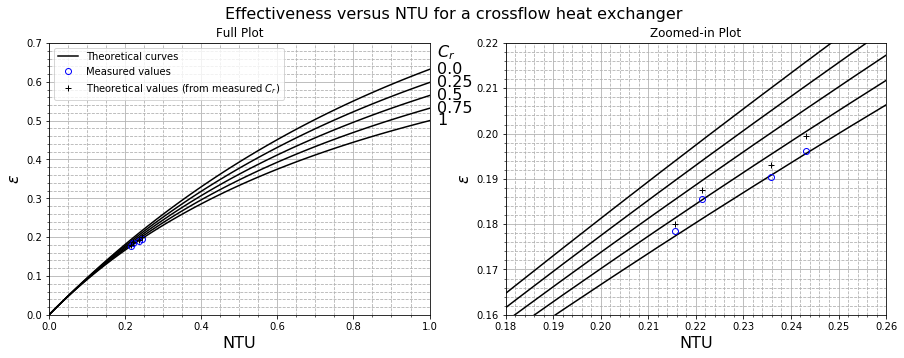

In [10]:
# Figure 1c
# Generate EffectivenessNTU figure
# Plot effectiveness versus NTU and Cr for crossflow heat exchanger

def build_EffectivenessNTU_figure(ax, xlim, ylim, plot_text, NTU, epsilon, epsilon_ther):
    Cr_plotvals=np.array([0,.25,.5,.75])
    NTU_plotvals=np.linspace(0,1,100)
    e_plotvals=np.zeros((100,5))
    ax.minorticks_on()
    ax.grid(b=True, which='major', axis='both', linestyle='-')
    ax.grid(b=True, which='minor', axis='both', linestyle='--')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('NTU', fontsize=16)
    ax.set_ylabel(r'$\epsilon$', fontsize=16)
    for k in range(Cr_plotvals.size):
        e_plotvals[:,k]=(1-np.exp(-NTU_plotvals*(1-Cr_plotvals[k])))/(1-Cr_plotvals[k]*np.exp(-NTU_plotvals*(1-Cr_plotvals[k])))
        ax.plot(NTU_plotvals,e_plotvals[:,k],'k-')
        if(plot_text):
            ax.text(NTU_plotvals[-1]*1.02,e_plotvals[-1,k]*.98,str(Cr_plotvals[k]), fontsize=16)
    k=k+1
    e_plotvals[:,k]=NTU_plotvals/(1+NTU_plotvals)
    ax.plot(NTU_plotvals,e_plotvals[:,k],'k-', label='Theoretical curves')
    ax.plot(NTU,epsilon,'bo', fillstyle='none', label='Measured values')
    ax.plot(NTU,epsilon_ther,'k+', label='Theoretical values (from measured $C_r$)')
    if(plot_text):
        ax.text(NTU_plotvals[-1]*1.02,e_plotvals[-1,k]*.98,'1', fontsize=16)
        ax.text(NTU_plotvals[-1]*1.02,e_plotvals[-1,1]*1.11,r'$C_r$', fontsize=16)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Effectiveness versus NTU for a crossflow heat exchanger', fontsize=16)
build_EffectivenessNTU_figure(ax1, (0,1), (0,0.7), True, NTU, epsilon, epsilon_ther)
ax1.legend()
ax1.set_title('Full Plot')
build_EffectivenessNTU_figure(ax2, (0.18,0.26), (0.16,0.22), False, NTU, epsilon, epsilon_ther)
ax2.set_title('Zoomed-in Plot')
plt.show()

In [11]:
# 2a 
print('deltaq is {:s}%'.format(str(deltaq)))
print('sigmaq_c_per_qc is {:s}% and sigmaq_h_per_qh is {:s}%'.format(str(sigmaq_c_per_qc), str(sigmaq_h_per_qh)))


deltaq is [ 9.111 18.776 10.847 15.189]%
sigmaq_c_per_qc is [5.466 5.603 6.404 6.053]% and sigmaq_h_per_qh is [4.759 6.818 4.587 6.823]%


In [12]:
# 2b 
print('deltaepsilon is {:s}%'.format(str(deltaepsilon)))


deltaepsilon is [0.865 1.616 1.098 1.36 ]%


In [13]:
# 2c
print('qconv on average is {:s}kW and qrad on average is {:s}kW'.format(str(np.mean(qconv/1000)), str(np.mean(qrad/1000))))

qconv on average is 0.0025996902923571714kW and qrad on average is 0.0033480481621970615kW
